In [1]:
import numpy as np
import pandas as pd
import os, re, time, math, tqdm, itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
import plotly.offline as pyo
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# !pip install interpret
# from interpret.blackbox import LimeTabular
# from interpret import show

import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer
import graphviz
import shap

import pickle

import warnings
warnings.filterwarnings("ignore")

**Load Dataset**

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input/ids-intrusion-csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ids-intrusion-csv/02-28-2018.csv
/kaggle/input/ids-intrusion-csv/03-01-2018.csv
/kaggle/input/ids-intrusion-csv/02-16-2018.csv
/kaggle/input/ids-intrusion-csv/02-15-2018.csv
/kaggle/input/ids-intrusion-csv/02-21-2018.csv
/kaggle/input/ids-intrusion-csv/03-02-2018.csv
/kaggle/input/ids-intrusion-csv/02-22-2018.csv
/kaggle/input/ids-intrusion-csv/02-20-2018.csv
/kaggle/input/ids-intrusion-csv/02-14-2018.csv
/kaggle/input/ids-intrusion-csv/02-23-2018.csv


**Read Dataset**

In [3]:
%%time
network_data_d1 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-14-2018.csv", low_memory=False)
network_data_d2 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-15-2018.csv", low_memory=False)
network_data_d3 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-16-2018.csv", low_memory=False)
network_data_d4 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-20-2018.csv", low_memory=False)
network_data_d5 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-21-2018.csv", low_memory=False)
network_data_d6 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-22-2018.csv", low_memory=False)
network_data_d7 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-23-2018.csv", low_memory=False)
network_data_d8 = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-28-2018.csv", low_memory=False)
network_data_d9 = pd.read_csv("/kaggle/input/ids-intrusion-csv/03-01-2018.csv", low_memory=False)
network_data_d10 = pd.read_csv("/kaggle/input/ids-intrusion-csv/03-02-2018.csv", low_memory=False)

CPU times: user 5min 42s, sys: 58.2 s, total: 6min 40s
Wall time: 8min 2s


In [4]:
network_data_d4.drop(columns=['Flow ID', 'Src IP', 'Src Port', 'Dst IP'], axis=1,inplace=True)

**Data Type Fix**

In [5]:
def fixDataType(df_dataset):
    
    df_dataset = df_dataset[df_dataset['Dst Port'] != 'Dst Port']
    
    df_dataset['Dst Port'] = df_dataset['Dst Port'].astype(int)
    df_dataset['Protocol'] = df_dataset['Protocol'].astype(int)
    df_dataset['Flow Duration'] = df_dataset['Flow Duration'].astype(int)
    df_dataset['Tot Fwd Pkts'] = df_dataset['Tot Fwd Pkts'].astype(int)
    df_dataset['Tot Bwd Pkts'] = df_dataset['Tot Bwd Pkts'].astype(int)
    df_dataset['TotLen Fwd Pkts'] = df_dataset['TotLen Fwd Pkts'].astype(int)
    df_dataset['TotLen Bwd Pkts'] = df_dataset['TotLen Bwd Pkts'].astype(int)
    df_dataset['Fwd Pkt Len Max'] = df_dataset['Fwd Pkt Len Max'].astype(int)
    df_dataset['Fwd Pkt Len Min'] = df_dataset['Fwd Pkt Len Min'].astype(int)
    df_dataset['Fwd Pkt Len Mean'] = df_dataset['Fwd Pkt Len Mean'].astype(float)
    df_dataset['Fwd Pkt Len Std'] = df_dataset['Fwd Pkt Len Std'].astype(float)
    df_dataset['Bwd Pkt Len Max'] = df_dataset['Bwd Pkt Len Max'].astype(int)
    df_dataset['Bwd Pkt Len Min'] = df_dataset['Bwd Pkt Len Min'].astype(int)
    df_dataset['Bwd Pkt Len Mean'] = df_dataset['Bwd Pkt Len Mean'].astype(float)
    df_dataset['Bwd Pkt Len Std'] = df_dataset['Bwd Pkt Len Std'].astype(float)
    df_dataset['Flow Byts/s'] = df_dataset['Flow Byts/s'].astype(float)
    df_dataset['Flow Pkts/s'] = df_dataset['Flow Pkts/s'].astype(float)
    df_dataset['Flow IAT Mean'] = df_dataset['Flow IAT Mean'].astype(float)
    df_dataset['Flow IAT Std'] = df_dataset['Flow IAT Std'].astype(float)
    df_dataset['Flow IAT Max'] = df_dataset['Flow IAT Max'].astype(int)
    df_dataset['Flow IAT Min'] = df_dataset['Flow IAT Min'].astype(int)
    df_dataset['Fwd IAT Tot'] = df_dataset['Fwd IAT Tot'].astype(int)
    df_dataset['Fwd IAT Mean'] = df_dataset['Fwd IAT Mean'].astype(float)
    df_dataset['Fwd IAT Std'] = df_dataset['Fwd IAT Std'].astype(float)
    df_dataset['Fwd IAT Max'] = df_dataset['Fwd IAT Max'].astype(int)
    df_dataset['Fwd IAT Min'] = df_dataset['Fwd IAT Min'].astype(int)
    df_dataset['Bwd IAT Tot'] = df_dataset['Bwd IAT Tot'].astype(int)
    df_dataset['Bwd IAT Mean'] = df_dataset['Bwd IAT Mean'].astype(float)
    df_dataset['Bwd IAT Std'] = df_dataset['Bwd IAT Std'].astype(float)
    df_dataset['Bwd IAT Max'] = df_dataset['Bwd IAT Max'].astype(int)
    df_dataset['Bwd IAT Min'] = df_dataset['Bwd IAT Min'].astype(int)
    df_dataset['Fwd PSH Flags'] = df_dataset['Fwd PSH Flags'].astype(int)
    df_dataset['Bwd PSH Flags'] = df_dataset['Bwd PSH Flags'].astype(int)
    df_dataset['Fwd URG Flags'] = df_dataset['Fwd URG Flags'].astype(int)
    df_dataset['Bwd URG Flags'] = df_dataset['Bwd URG Flags'].astype(int)
    df_dataset['Fwd Header Len'] = df_dataset['Fwd Header Len'].astype(int)
    df_dataset['Bwd Header Len'] = df_dataset['Bwd Header Len'].astype(int)
    df_dataset['Fwd Pkts/s'] = df_dataset['Fwd Pkts/s'].astype(float)
    df_dataset['Bwd Pkts/s'] = df_dataset['Bwd Pkts/s'].astype(float)
    df_dataset['Pkt Len Min'] = df_dataset['Pkt Len Min'].astype(int)
    df_dataset['Pkt Len Max'] = df_dataset['Pkt Len Max'].astype(int)
    df_dataset['Pkt Len Mean'] = df_dataset['Pkt Len Mean'].astype(float)
    df_dataset['Pkt Len Std'] = df_dataset['Pkt Len Std'].astype(float)
    df_dataset['Pkt Len Var'] = df_dataset['Pkt Len Var'].astype(float)
    df_dataset['FIN Flag Cnt'] = df_dataset['FIN Flag Cnt'].astype(int)
    df_dataset['SYN Flag Cnt'] = df_dataset['SYN Flag Cnt'].astype(int)
    df_dataset['RST Flag Cnt'] = df_dataset['RST Flag Cnt'].astype(int)
    df_dataset['PSH Flag Cnt'] = df_dataset['PSH Flag Cnt'].astype(int)
    df_dataset['ACK Flag Cnt'] = df_dataset['ACK Flag Cnt'].astype(int)
    df_dataset['URG Flag Cnt'] = df_dataset['URG Flag Cnt'].astype(int)
    df_dataset['CWE Flag Count'] = df_dataset['CWE Flag Count'].astype(int)
    df_dataset['ECE Flag Cnt'] = df_dataset['ECE Flag Cnt'].astype(int)
    df_dataset['Down/Up Ratio'] = df_dataset['Down/Up Ratio'].astype(int)
    df_dataset['Pkt Size Avg'] = df_dataset['Pkt Size Avg'].astype(float)
    df_dataset['Fwd Seg Size Avg'] = df_dataset['Fwd Seg Size Avg'].astype(float)
    df_dataset['Bwd Seg Size Avg'] = df_dataset['Bwd Seg Size Avg'].astype(float)
    df_dataset['Fwd Byts/b Avg'] = df_dataset['Fwd Byts/b Avg'].astype(int)
    df_dataset['Fwd Pkts/b Avg'] = df_dataset['Fwd Pkts/b Avg'].astype(int)
    df_dataset['Fwd Blk Rate Avg'] = df_dataset['Fwd Blk Rate Avg'].astype(int)
    df_dataset['Bwd Byts/b Avg'] = df_dataset['Bwd Byts/b Avg'].astype(int)
    df_dataset['Bwd Pkts/b Avg'] = df_dataset['Bwd Pkts/b Avg'].astype(int)
    df_dataset['Bwd Blk Rate Avg'] = df_dataset['Bwd Blk Rate Avg'].astype(int)
    df_dataset['Subflow Fwd Pkts'] = df_dataset['Subflow Fwd Pkts'].astype(int)
    df_dataset['Subflow Fwd Byts'] = df_dataset['Subflow Fwd Byts'].astype(int)
    df_dataset['Subflow Bwd Pkts'] = df_dataset['Subflow Bwd Pkts'].astype(int)
    df_dataset['Subflow Bwd Byts'] = df_dataset['Subflow Bwd Byts'].astype(int)
    df_dataset['Init Fwd Win Byts'] = df_dataset['Init Fwd Win Byts'].astype(int)
    df_dataset['Init Bwd Win Byts'] = df_dataset['Init Bwd Win Byts'].astype(int)
    df_dataset['Fwd Act Data Pkts'] = df_dataset['Fwd Act Data Pkts'].astype(int)
    df_dataset['Fwd Seg Size Min'] = df_dataset['Fwd Seg Size Min'].astype(int)
    df_dataset['Active Mean'] = df_dataset['Active Mean'].astype(float)
    df_dataset['Active Std'] = df_dataset['Active Std'].astype(float)
    df_dataset['Active Max'] = df_dataset['Active Max'].astype(int)
    df_dataset['Active Min'] = df_dataset['Active Min'].astype(int)
    df_dataset['Idle Mean'] = df_dataset['Idle Mean'].astype(float)
    df_dataset['Idle Std'] = df_dataset['Idle Std'].astype(float)
    df_dataset['Idle Max'] = df_dataset['Idle Max'].astype(int)
    df_dataset['Idle Min'] = df_dataset['Idle Min'].astype(int)
    
    return df_dataset

In [6]:
%%time
# network_data_d1 = fixDataType(network_data_d1)
# network_data_d2 = fixDataType(network_data_d2)
network_data_d3 = fixDataType(network_data_d3)
# network_data_d4 = fixDataType(network_data_d4)
# network_data_d5 = fixDataType(network_data_d5)
# network_data_d6 = fixDataType(network_data_d6)
# network_data_d7 = fixDataType(network_data_d7)
network_data_d8 = fixDataType(network_data_d8)
network_data_d9 = fixDataType(network_data_d9)
# network_data_d10 = fixDataType(network_data_d10)

CPU times: user 28.8 s, sys: 733 ms, total: 29.5 s
Wall time: 29.5 s


**EDA**

In [7]:
def dataProperties(df, day):
    print(day)
    df.shape
    print ('Number of rows (Samples): ' , df.shape[0])
    print ('Number of columns (Features): ' , df.shape[1])
#     print(df)
#     print(df.info())
    print(df['Label'].value_counts())
    print("\n\n\n")

In [8]:
%%time
dataProperties(network_data_d1, "Day 1")
dataProperties(network_data_d2, "Day 2")
dataProperties(network_data_d3, "Day 3")
dataProperties(network_data_d4, "Day 4")
dataProperties(network_data_d5, "Day 5")
dataProperties(network_data_d6, "Day 6")
dataProperties(network_data_d7, "Day 7")
dataProperties(network_data_d8, "Day 8")
dataProperties(network_data_d9, "Day 9")
dataProperties(network_data_d10, "Day 10")

Day 1
Number of rows (Samples):  1048575
Number of columns (Features):  80
Label
Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: count, dtype: int64




Day 2
Number of rows (Samples):  1048575
Number of columns (Features):  80
Label
Benign                   996077
DoS attacks-GoldenEye     41508
DoS attacks-Slowloris     10990
Name: count, dtype: int64




Day 3
Number of rows (Samples):  1048574
Number of columns (Features):  80
Label
DoS attacks-Hulk            461912
Benign                      446772
DoS attacks-SlowHTTPTest    139890
Name: count, dtype: int64




Day 4
Number of rows (Samples):  7948748
Number of columns (Features):  80
Label
Benign                    7372557
DDoS attacks-LOIC-HTTP     576191
Name: count, dtype: int64




Day 5
Number of rows (Samples):  1048575
Number of columns (Features):  80
Label
DDOS attack-HOIC        686012
Benign                  360833
DDOS attack-LOIC-UDP      1730
Name: count, dtype: int64




Day 6
Nu

**Data Visualizations**

In [9]:
def visualizeBar(df):
    # bar chart of packets label
    plt.figure(figsize=(10, 5))
    plt.title('Packet Distribution')
    # plt.bar(x=['Benign', 'FTP-BruteForce', 'SSH-Bruteforce'], height=network_data['Label'].value_counts(), color=['blue', 'magenta', 'cyan'])
    plt.bar(x=df['Label'].unique(), height=df['Label'].value_counts())
    p = plt.gcf()

CPU times: user 3.86 s, sys: 7.61 ms, total: 3.86 s
Wall time: 3.87 s


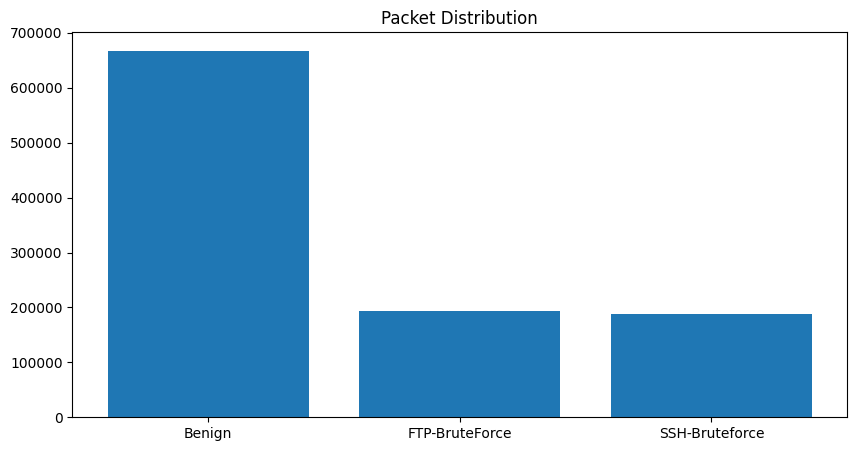

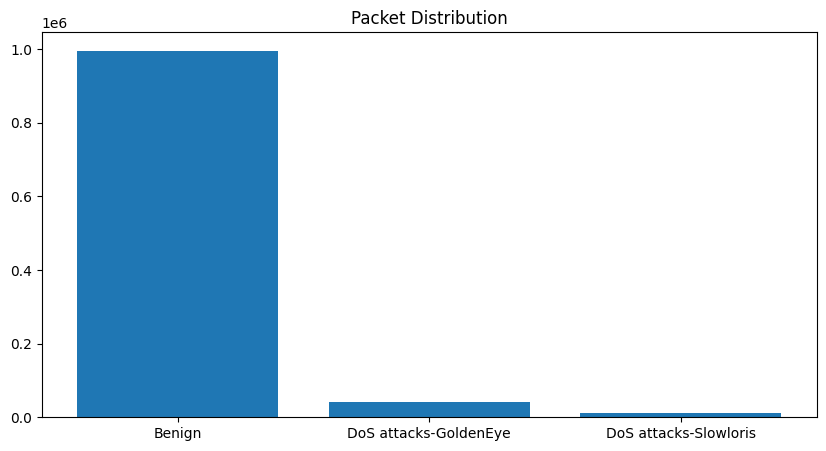

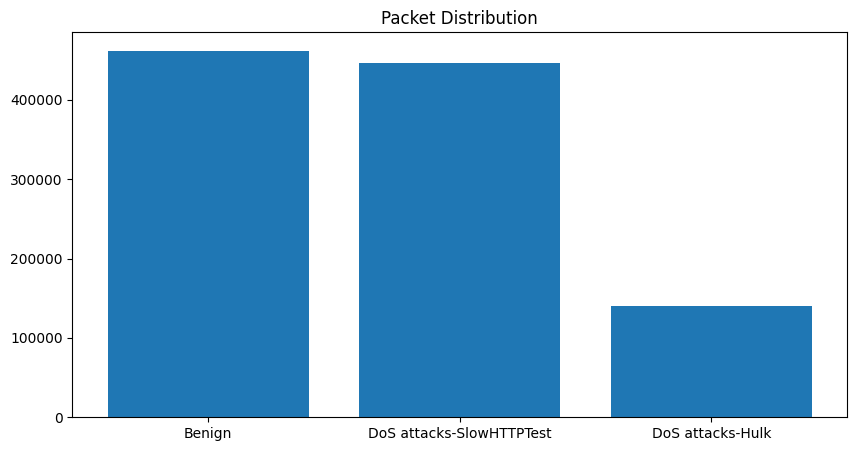

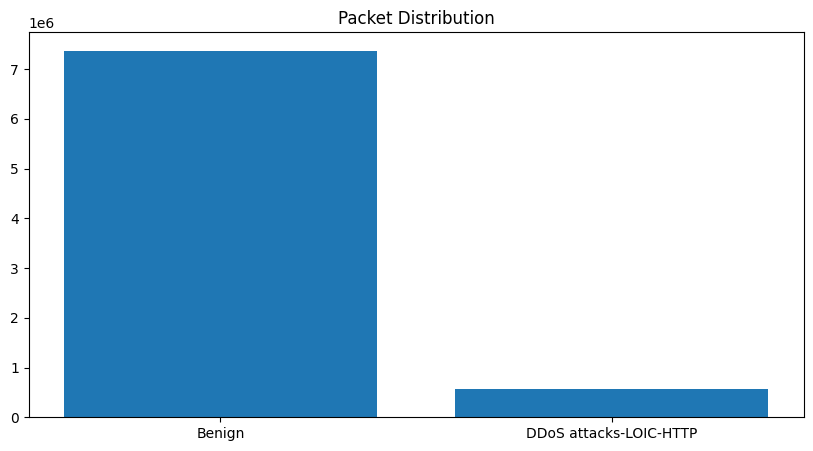

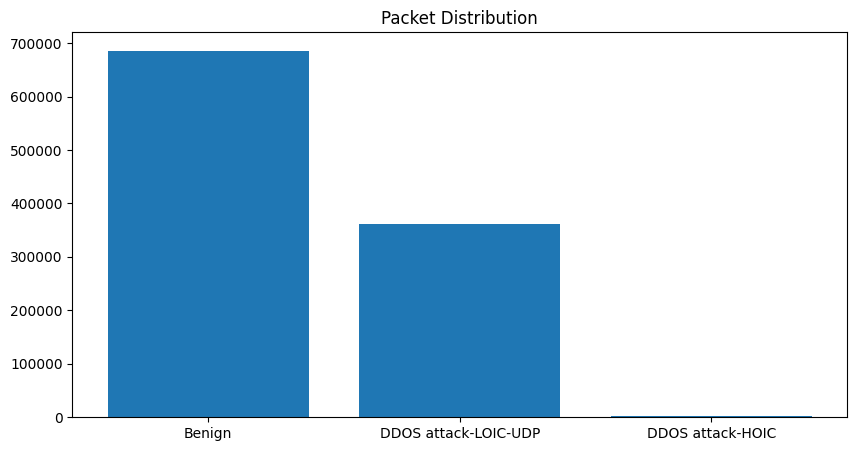

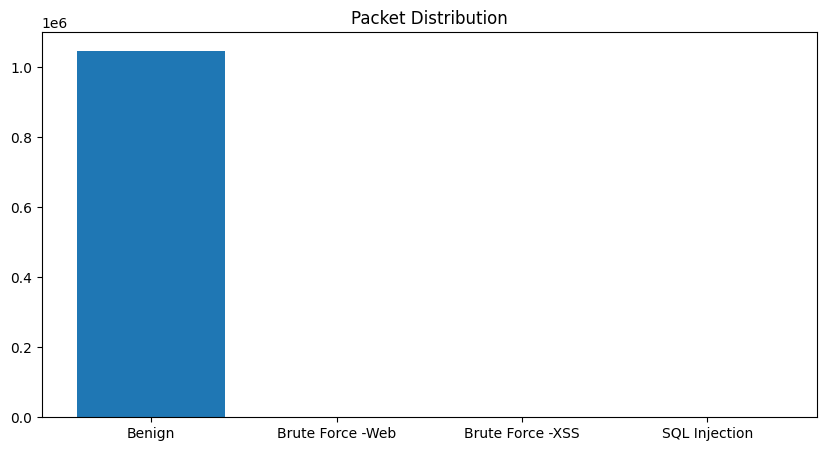

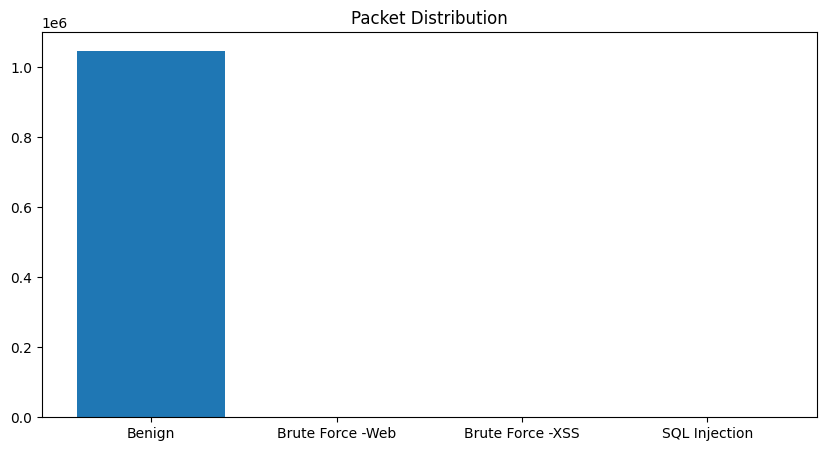

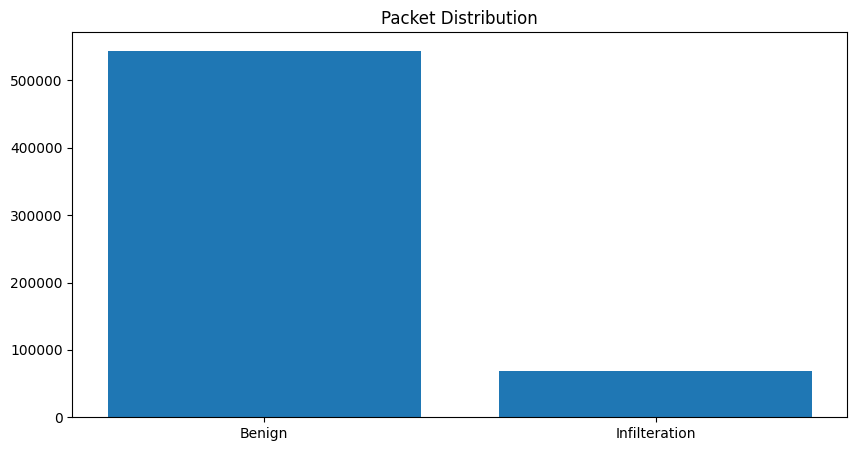

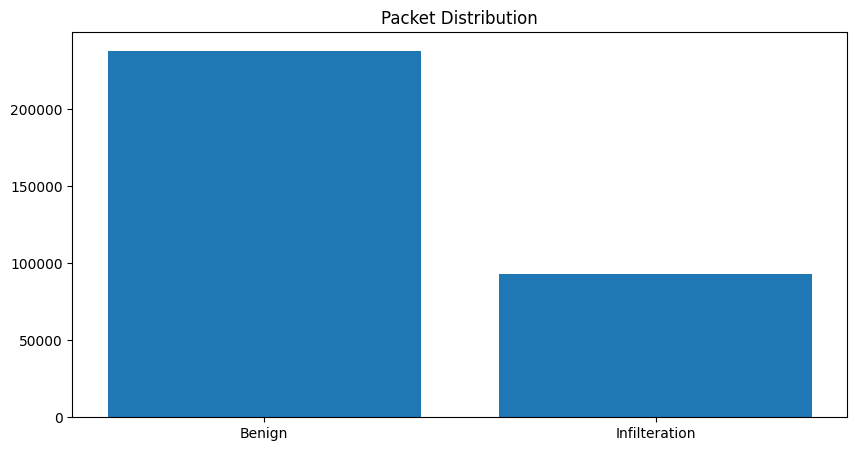

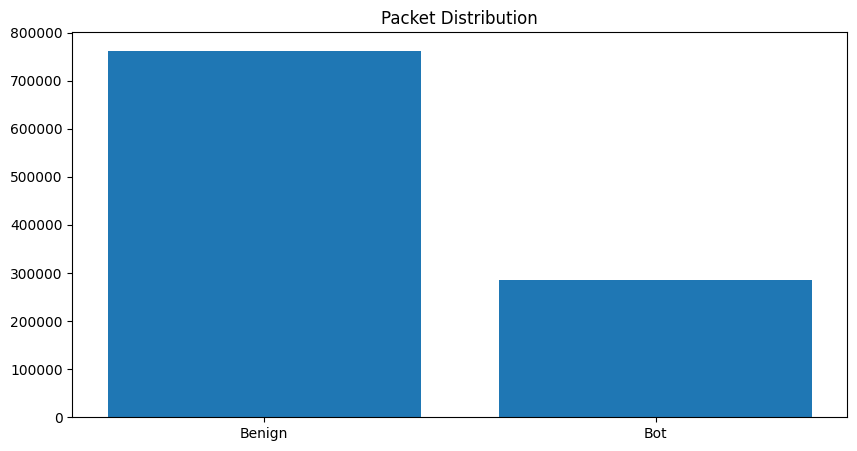

In [10]:
%%time
# network_data = dropInfinateNull(network_data)
visualizeBar(network_data_d1)
visualizeBar(network_data_d2)
visualizeBar(network_data_d3)
visualizeBar(network_data_d4)
visualizeBar(network_data_d5)
visualizeBar(network_data_d6)
visualizeBar(network_data_d7)
visualizeBar(network_data_d8)
visualizeBar(network_data_d9)
visualizeBar(network_data_d10)

**isualizations with Pie Chart**

In [11]:
def visualizePie(df):
    # pie chart of packets label
    plt.figure(figsize=(5, 5))
    circle = plt.Circle((0, 0), 0.7, color='white')
    plt.title('Packet Distribution')
    # plt.pie(network_data_d1['Label'].value_counts(), labels=['Benign', 'FTP-BruteForce', 'SSH-Bruteforce'], colors=['blue', 'magenta', 'cyan'])
    plt.pie(df['Label'].value_counts(), labels=df['Label'].unique())
    p = plt.gcf()
    p.gca().add_artist(circle)

CPU times: user 4.36 s, sys: 13.4 ms, total: 4.37 s
Wall time: 4.38 s


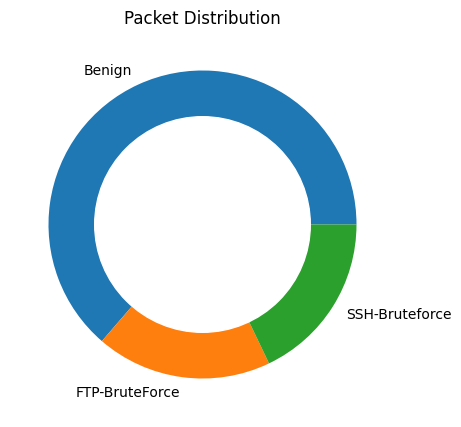

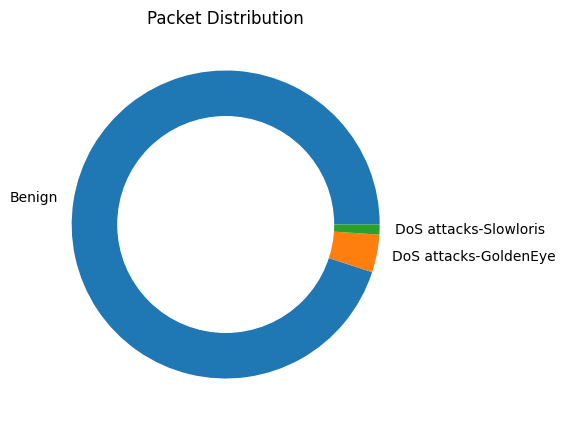

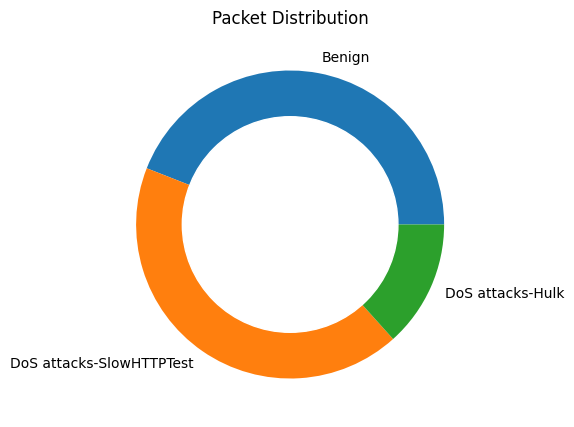

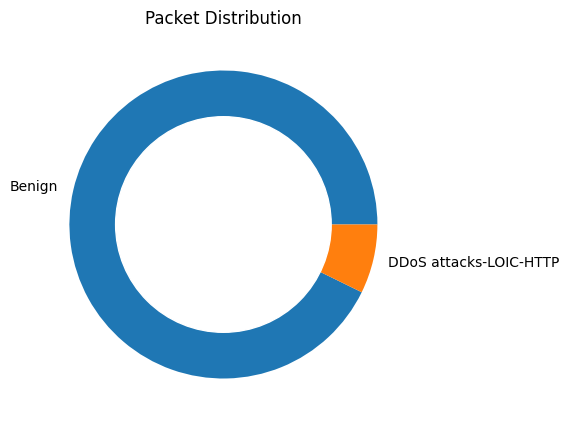

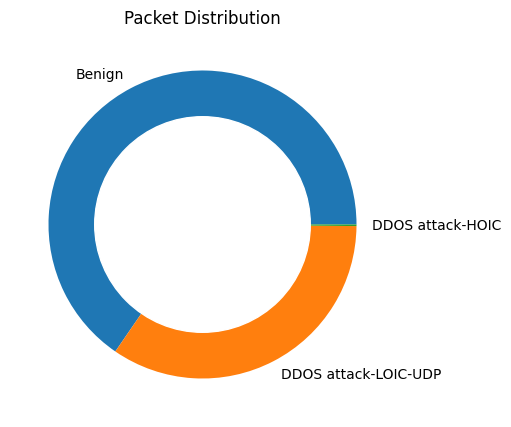

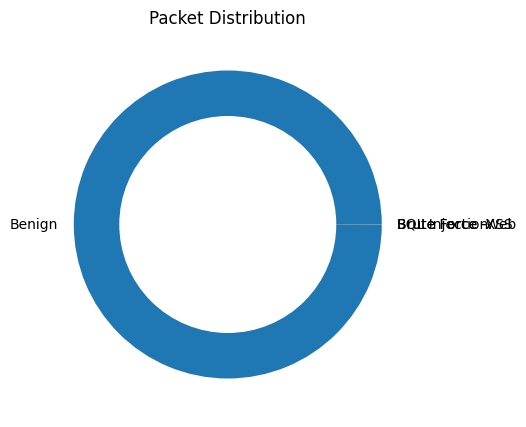

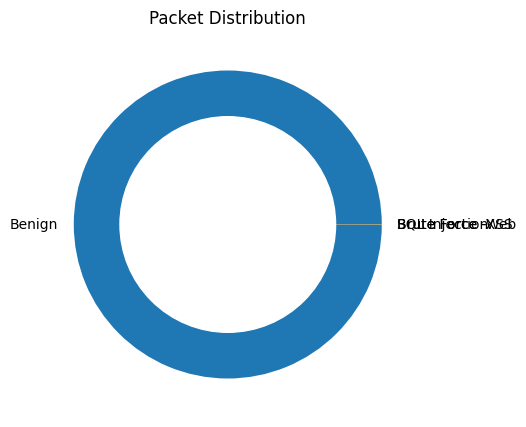

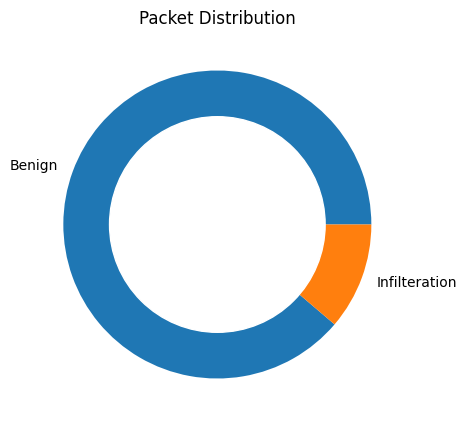

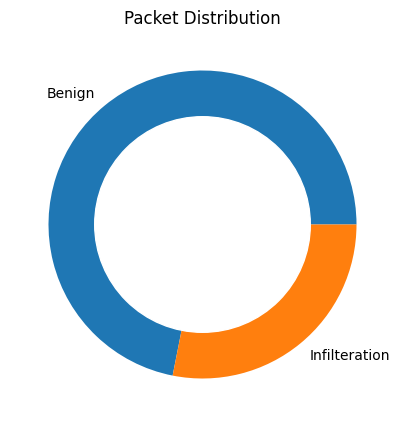

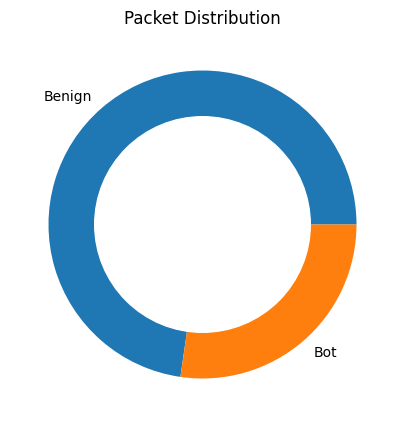

In [12]:
%%time
# network_data = dropInfinateNull(network_data)
visualizePie(network_data_d1)
visualizePie(network_data_d2)
visualizePie(network_data_d3)
visualizePie(network_data_d4)
visualizePie(network_data_d5)
visualizePie(network_data_d6)
visualizePie(network_data_d7)
visualizePie(network_data_d8)
visualizePie(network_data_d9)
visualizePie(network_data_d10)

**Data Preprocessing**

In [13]:
def dropInfinateNull(df):
    print (df.shape)

    # replace infinity value as null value
    df = df.replace(["Infinity", "infinity"], np.inf)
    df = df.replace([np.inf, -np.inf], np.nan)

    # drop all null values
    df.dropna(inplace=True)

    print (df.shape)
    
    return df

In [14]:
%%time
# network_data = dropInfinateNull(network_data)
network_data_d1 = dropInfinateNull(network_data_d1)
network_data_d2 = dropInfinateNull(network_data_d2)
network_data_d3 = dropInfinateNull(network_data_d3)
network_data_d4 = dropInfinateNull(network_data_d4)
network_data_d5 = dropInfinateNull(network_data_d5)
network_data_d6 = dropInfinateNull(network_data_d6)
network_data_d7 = dropInfinateNull(network_data_d7)
network_data_d8 = dropInfinateNull(network_data_d8)
network_data_d9 = dropInfinateNull(network_data_d9)
network_data_d10 = dropInfinateNull(network_data_d10)

(1048575, 80)
(1044751, 80)
(1048575, 80)
(1040548, 80)
(1048574, 80)
(1048574, 80)
(7948748, 80)
(7889295, 80)
(1048575, 80)
(1048575, 80)
(1048575, 80)
(1042965, 80)
(1048575, 80)
(1042867, 80)
(613071, 80)
(606902, 80)
(331100, 80)
(328181, 80)
(1048575, 80)
(1044525, 80)
CPU times: user 38.5 s, sys: 17.1 s, total: 55.6 s
Wall time: 55.8 s


**Drop Unnecessary Column**

In [15]:
def dropUnnecessaryColumn(df): 
    df.drop(columns="Timestamp", inplace=True)
    print (df.shape)
    return df

In [16]:
%%time
# network_data = dropInfinateNull(network_data)
network_data_d1 = dropUnnecessaryColumn(network_data_d1)
network_data_d2 = dropUnnecessaryColumn(network_data_d2)
network_data_d3 = dropUnnecessaryColumn(network_data_d3)
network_data_d4 = dropUnnecessaryColumn(network_data_d4)
network_data_d5 = dropUnnecessaryColumn(network_data_d5)
network_data_d6 = dropUnnecessaryColumn(network_data_d6)
network_data_d7 = dropUnnecessaryColumn(network_data_d7)
network_data_d8 = dropUnnecessaryColumn(network_data_d8)
network_data_d9 = dropUnnecessaryColumn(network_data_d9)
network_data_d10 = dropUnnecessaryColumn(network_data_d10)

(1044751, 79)
(1040548, 79)
(1048574, 79)
(7889295, 79)
(1048575, 79)
(1042965, 79)
(1042867, 79)
(606902, 79)
(328181, 79)
(1044525, 79)
CPU times: user 2.13 s, sys: 2.01 s, total: 4.15 s
Wall time: 4.16 s


**Transform Target Label into Binary Class**

In [17]:
%%time
def transformTargetLabelToBinary(df):
    # encode the target feature
    df['Label'] = df['Label'].apply(lambda x: "Benign" if x == 'Benign' else "Malicious")
    print(df['Label'].unique())
    print(df['Label'].value_counts())
    return df

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 12.2 µs


In [18]:
%%time
# network_data = dropInfinateNull(network_data)
network_data_d1 = transformTargetLabelToBinary(network_data_d1)
network_data_d2 = transformTargetLabelToBinary(network_data_d2)
network_data_d3 = transformTargetLabelToBinary(network_data_d3)
network_data_d4 = transformTargetLabelToBinary(network_data_d4)
network_data_d5 = transformTargetLabelToBinary(network_data_d5)
network_data_d6 = transformTargetLabelToBinary(network_data_d6)
network_data_d7 = transformTargetLabelToBinary(network_data_d7)
network_data_d8 = transformTargetLabelToBinary(network_data_d8)
network_data_d9 = transformTargetLabelToBinary(network_data_d9)
network_data_d10 = transformTargetLabelToBinary(network_data_d10)

['Benign' 'Malicious']
Label
Benign       663808
Malicious    380943
Name: count, dtype: int64
['Benign' 'Malicious']
Label
Benign       988050
Malicious     52498
Name: count, dtype: int64
['Benign' 'Malicious']
Label
Malicious    601802
Benign       446772
Name: count, dtype: int64
['Benign' 'Malicious']
Label
Benign       7313104
Malicious     576191
Name: count, dtype: int64
['Benign' 'Malicious']
Label
Malicious    687742
Benign       360833
Name: count, dtype: int64
['Benign' 'Malicious']
Label
Benign       1042603
Malicious        362
Name: count, dtype: int64
['Benign' 'Malicious']
Label
Benign       1042301
Malicious        566
Name: count, dtype: int64
['Benign' 'Malicious']
Label
Benign       538666
Malicious     68236
Name: count, dtype: int64
['Benign' 'Malicious']
Label
Benign       235778
Malicious     92403
Name: count, dtype: int64
['Benign' 'Malicious']
Label
Benign       758334
Malicious    286191
Name: count, dtype: int64
CPU times: user 9.04 s, sys: 13.8 ms, total:

**Split data & Oversampling**

In [19]:
%%time
def balanceData(df):
    # split data into features and target
    X=df.drop(["Label"], axis=1)
    y=df["Label"]

    # applying oversampling
    rus = RandomUnderSampler()
    X_balanced, y_balanced = rus.fit_resample(X, y) # insted of X, y use the direct syntex

    df = pd.concat([X_balanced, y_balanced], axis=1)
    del X, y, X_balanced, y_balanced
    print (df.shape)
    print(df['Label'].value_counts())
    
    return df

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 11.9 µs


In [20]:
%%time
# network_data = dropInfinateNull(network_data)
network_data_d1 = balanceData(network_data_d1)
network_data_d2 = balanceData(network_data_d2)
network_data_d3 = balanceData(network_data_d3)
network_data_d4 = balanceData(network_data_d4)
network_data_d5 = balanceData(network_data_d5)
network_data_d6 = balanceData(network_data_d6)
network_data_d7 = balanceData(network_data_d7)
network_data_d8 = balanceData(network_data_d8)
network_data_d9 = balanceData(network_data_d9)
network_data_d10 = balanceData(network_data_d10)

(761886, 79)
Label
Benign       380943
Malicious    380943
Name: count, dtype: int64
(104996, 79)
Label
Benign       52498
Malicious    52498
Name: count, dtype: int64
(893544, 79)
Label
Benign       446772
Malicious    446772
Name: count, dtype: int64
(1152382, 79)
Label
Benign       576191
Malicious    576191
Name: count, dtype: int64
(721666, 79)
Label
Benign       360833
Malicious    360833
Name: count, dtype: int64
(724, 79)
Label
Benign       362
Malicious    362
Name: count, dtype: int64
(1132, 79)
Label
Benign       566
Malicious    566
Name: count, dtype: int64
(136472, 79)
Label
Benign       68236
Malicious    68236
Name: count, dtype: int64
(184806, 79)
Label
Benign       92403
Malicious    92403
Name: count, dtype: int64
(572382, 79)
Label
Benign       286191
Malicious    286191
Name: count, dtype: int64
CPU times: user 2min 1s, sys: 3.99 s, total: 2min 5s
Wall time: 2min 5s


**Take 20% Data**

In [21]:
import pandas as pd

def dataReduction(df):
    classes = df['Label'].unique()
    reduced_data = pd.DataFrame()
    for class_name in classes:
        class_data = df[df['Label'] == class_name]
        num_samples = int(0.2 * len(class_data))
        selected_samples = class_data.sample(n=num_samples, random_state=42)
        reduced_data = pd.concat([reduced_data, selected_samples], ignore_index=True)
    return reduced_data

# network_data = dropInfinateNull(network_data)
network_data_d1 = dataReduction(network_data_d1)
network_data_d2 = dataReduction(network_data_d2)
network_data_d3 = dataReduction(network_data_d3)
network_data_d4 = dataReduction(network_data_d4)
network_data_d5 = dataReduction(network_data_d5)
network_data_d6 = dataReduction(network_data_d6)
network_data_d7 = dataReduction(network_data_d7)
network_data_d8 = dataReduction(network_data_d8)
network_data_d9 = dataReduction(network_data_d9)
network_data_d10 = dataReduction(network_data_d10)

In [22]:
%%time
dataProperties(network_data_d1, "Day 1")
dataProperties(network_data_d2, "Day 2")
dataProperties(network_data_d3, "Day 3")
dataProperties(network_data_d4, "Day 4")
dataProperties(network_data_d5, "Day 5")
dataProperties(network_data_d6, "Day 6")
dataProperties(network_data_d7, "Day 7")
dataProperties(network_data_d8, "Day 8")
dataProperties(network_data_d9, "Day 9")
dataProperties(network_data_d10, "Day 10")

Day 1
Number of rows (Samples):  152376
Number of columns (Features):  79
Label
Benign       76188
Malicious    76188
Name: count, dtype: int64




Day 2
Number of rows (Samples):  20998
Number of columns (Features):  79
Label
Benign       10499
Malicious    10499
Name: count, dtype: int64




Day 3
Number of rows (Samples):  178708
Number of columns (Features):  79
Label
Benign       89354
Malicious    89354
Name: count, dtype: int64




Day 4
Number of rows (Samples):  230476
Number of columns (Features):  79
Label
Benign       115238
Malicious    115238
Name: count, dtype: int64




Day 5
Number of rows (Samples):  144332
Number of columns (Features):  79
Label
Benign       72166
Malicious    72166
Name: count, dtype: int64




Day 6
Number of rows (Samples):  144
Number of columns (Features):  79
Label
Benign       72
Malicious    72
Name: count, dtype: int64




Day 7
Number of rows (Samples):  226
Number of columns (Features):  79
Label
Benign       113
Malicious    113
Name: cou

**Data Concatenation**

In [23]:
%%time
network_data = pd.concat([network_data_d1, network_data_d2], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data_d1, network_data_d2

network_data = pd.concat([network_data, network_data_d3], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data_d3

# network_data = network_data_d3
# del network_data_d3

network_data = pd.concat([network_data, network_data_d4], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data_d4

network_data = pd.concat([network_data, network_data_d5], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data_d5

network_data = pd.concat([network_data, network_data_d6], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data_d6

network_data = pd.concat([network_data, network_data_d7], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data_d7

network_data = pd.concat([network_data, network_data_d8], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data_d8

network_data = pd.concat([network_data, network_data_d9], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data_d9

network_data = pd.concat([network_data, network_data_d10], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data_d10

CPU times: user 887 ms, sys: 5.81 ms, total: 893 ms
Wall time: 894 ms


In [24]:
network_data['Label'].value_counts()

Label
Benign       452995
Malicious    452995
Name: count, dtype: int64

**Feature Selection**




Drop Constant Column

In [25]:
%%time
# drop the constant columns (which varience is 0)
variances = network_data.var(numeric_only=True)
constant_columns = variances[variances == 0].index
network_data = network_data.drop(constant_columns, axis=1)

print(constant_columns)
print (network_data.shape)

Index(['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg',
       'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg',
       'Bwd Blk Rate Avg'],
      dtype='object')
(905990, 71)
CPU times: user 634 ms, sys: 10 µs, total: 634 ms
Wall time: 634 ms


**Check and Drop Duplicate Column**

In [26]:
%%time
duplicates = set()
for i in range(0, len(network_data.columns)):
    col1 = network_data.columns[i]
    for j in range(i+1, len(network_data.columns)):
        col2 = network_data.columns[j]
        if(network_data[col1].equals(network_data[col2])):
            duplicates.add(col2)

print (duplicates)
network_data.drop(duplicates, axis=1, inplace=True)
print (network_data.shape)

{'CWE Flag Count', 'Subflow Fwd Pkts', 'ECE Flag Cnt', 'SYN Flag Cnt', 'Subflow Bwd Pkts'}
(905990, 66)
CPU times: user 3.33 s, sys: 0 ns, total: 3.33 s
Wall time: 3.33 s


**Encode Target Label**

In [27]:
%%time
# encode the target feature
network_data['Label'] = network_data['Label'].apply(lambda x: 0 if x == 'Benign' else 1)
print(network_data['Label'].unique())

[0 1]
CPU times: user 705 ms, sys: 2.48 ms, total: 708 ms
Wall time: 715 ms


# Drop Column Based on Correlations

**Correlations of Data**

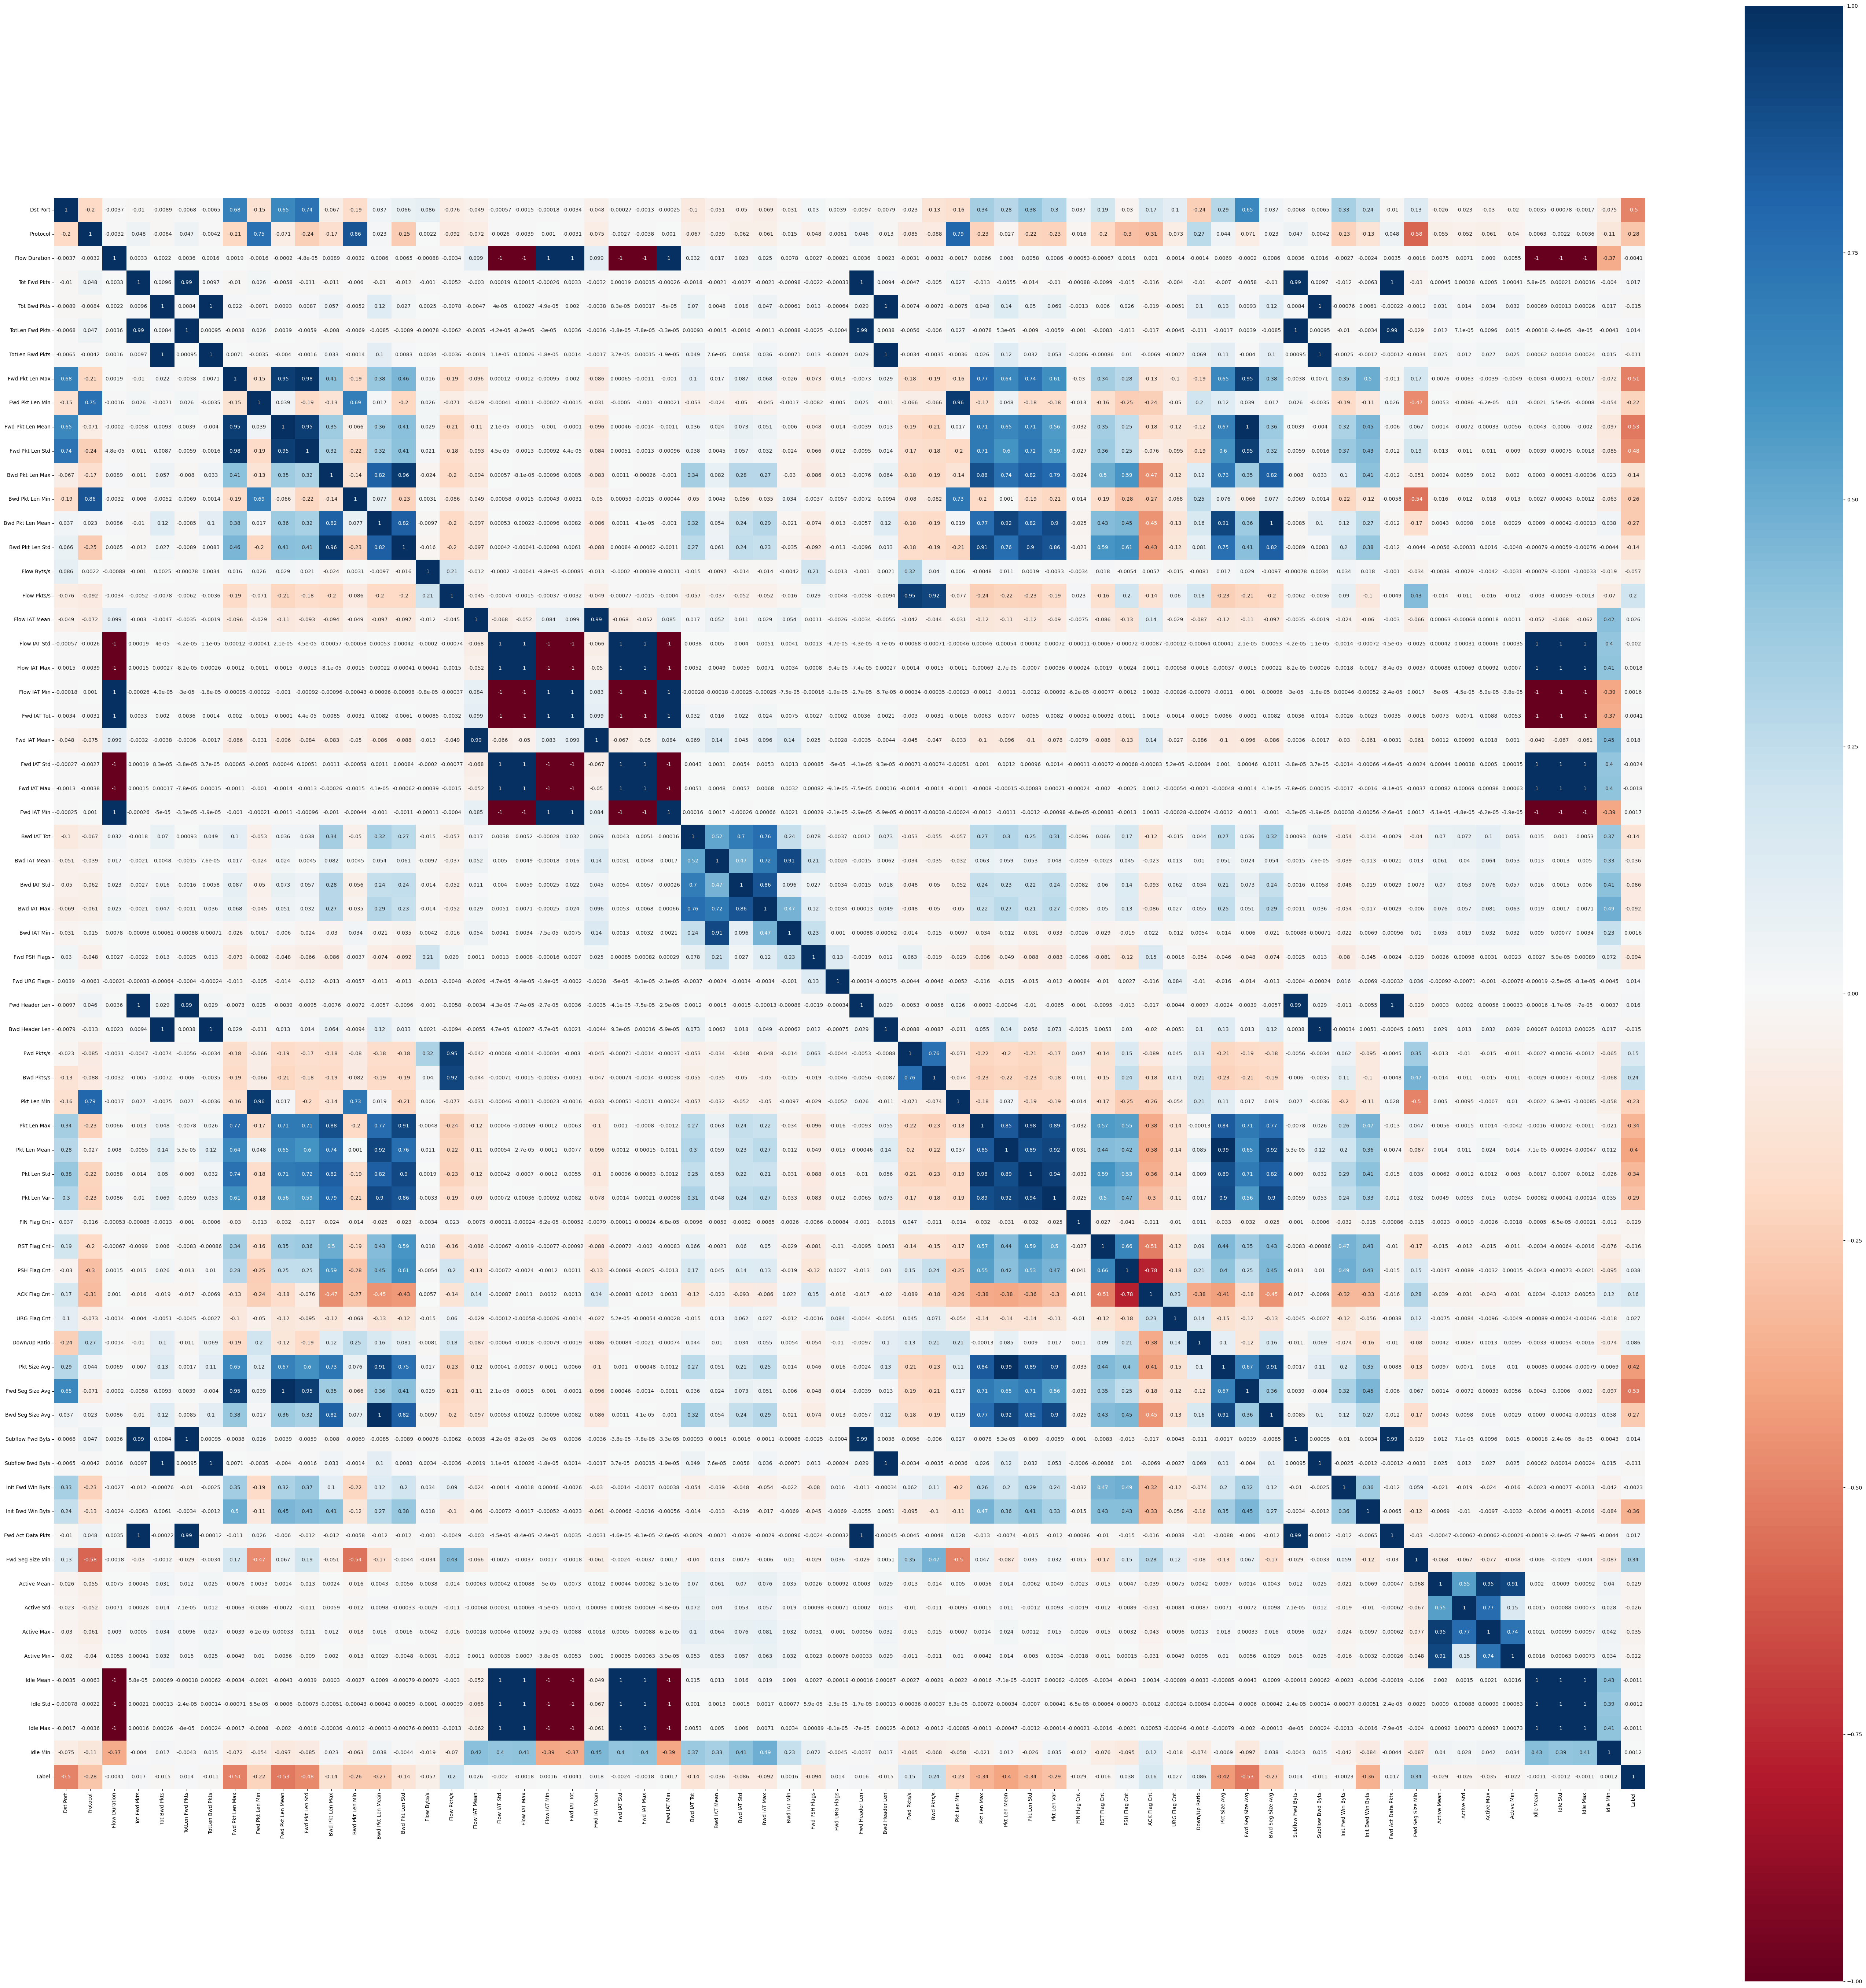

CPU times: user 24.3 s, sys: 523 ms, total: 24.8 s
Wall time: 24.7 s


In [28]:
%%time
# pearson correlation heatmap
plt.figure(figsize=(70, 70))
corr = network_data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, square=True) # annot=True
plt.show()

**Drop Columns**

In [29]:
%%time
correlated_col = set()
is_correlated = [True] * len(corr.columns)
threshold = 0.90
for i in range (len(corr.columns)):
    if(is_correlated[i]):
        for j in range(i):
          if (corr.iloc[i, j] >= threshold) and (is_correlated[j]):
            colname = corr.columns[j]
            is_correlated[j]=False
            correlated_col.add(colname)

print(correlated_col)
print(len(correlated_col))

{'Flow IAT Mean', 'Flow Pkts/s', 'Fwd IAT Max', 'Active Mean', 'Pkt Len Mean', 'Flow IAT Max', 'Fwd Pkt Len Std', 'Flow Duration', 'Pkt Len Max', 'Tot Bwd Pkts', 'Pkt Size Avg', 'Idle Mean', 'Bwd Pkt Len Mean', 'Fwd IAT Tot', 'Fwd Pkt Len Mean', 'TotLen Fwd Pkts', 'Flow IAT Std', 'Idle Std', 'Bwd Pkt Len Max', 'Pkt Len Var', 'Fwd Pkt Len Max', 'TotLen Bwd Pkts', 'Fwd Header Len', 'Pkt Len Std', 'Fwd Pkt Len Min', 'Tot Fwd Pkts', 'Subflow Fwd Byts', 'Bwd Header Len', 'Fwd IAT Std', 'Bwd IAT Mean', 'Bwd Pkt Len Std', 'Flow IAT Min'}
32
CPU times: user 91.3 ms, sys: 898 µs, total: 92.2 ms
Wall time: 92.7 ms


In [30]:
%%time
network_data.drop(correlated_col, axis=1, inplace=True)
print (network_data.shape)

(905990, 34)
CPU times: user 82.6 ms, sys: 1.37 ms, total: 84 ms
Wall time: 90.2 ms


**Correlations of Data**

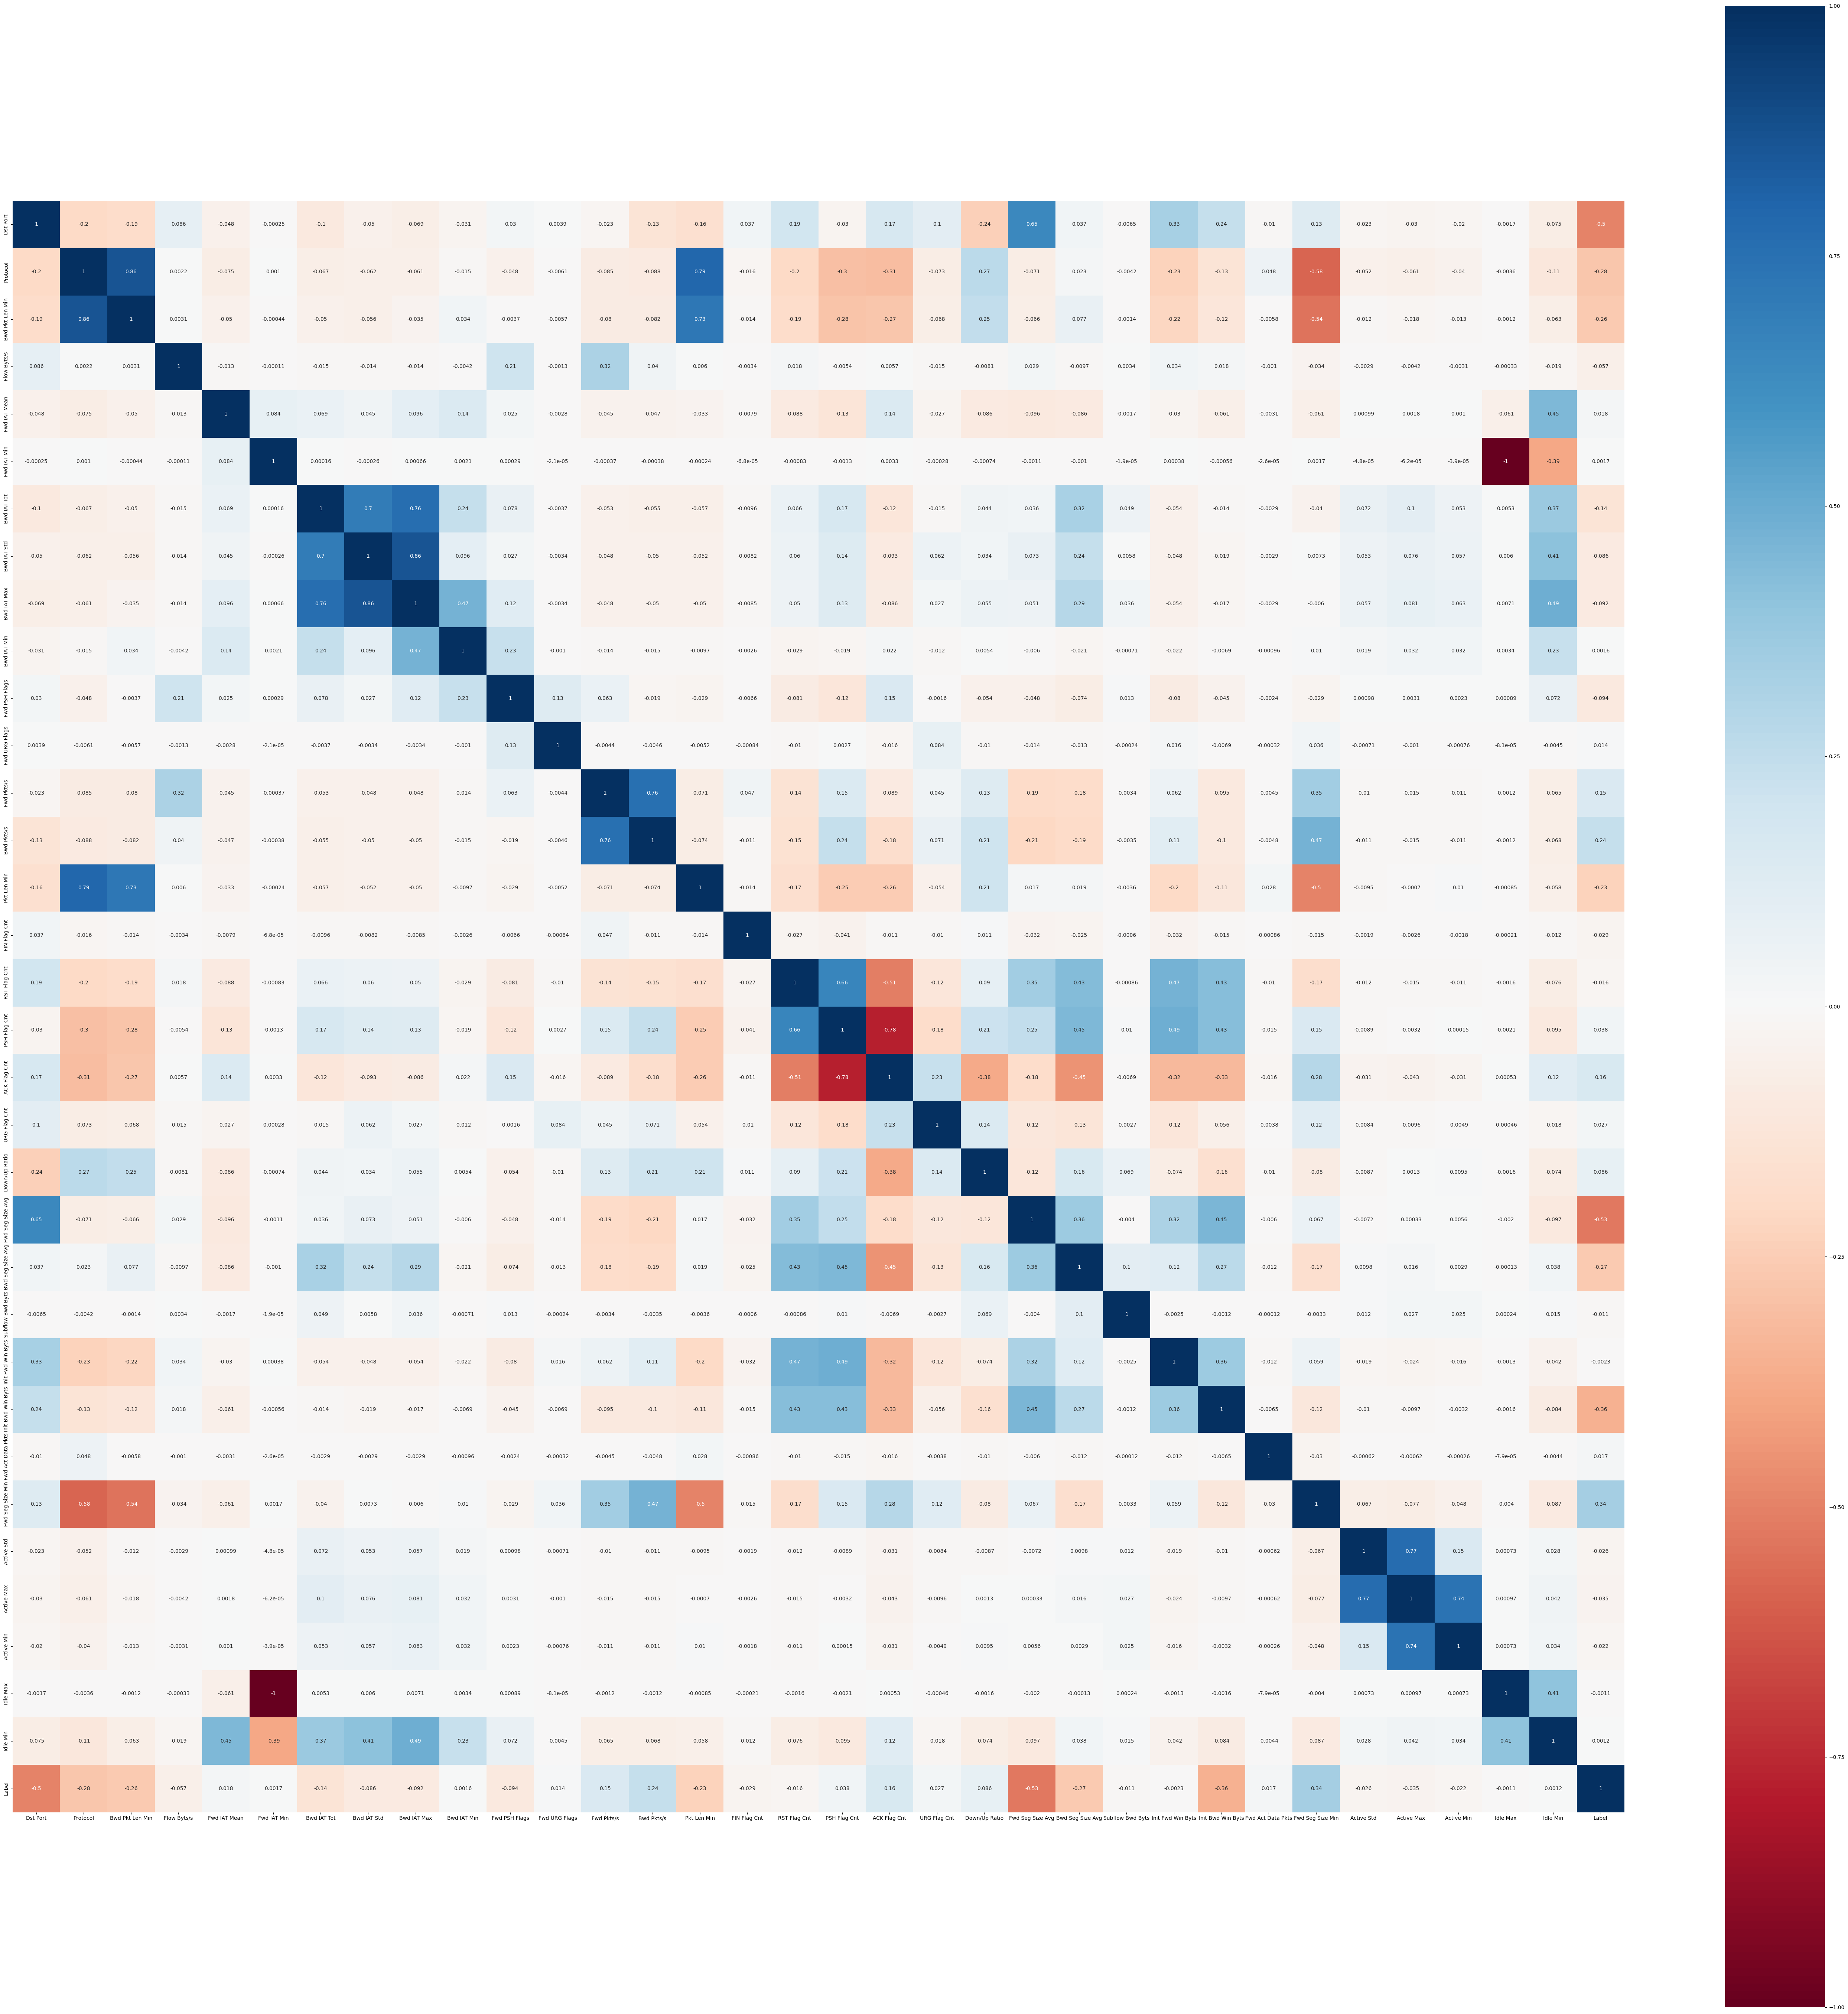

CPU times: user 9.49 s, sys: 220 ms, total: 9.71 s
Wall time: 9.77 s


In [31]:
%%time
# pearson correlation heatmap
plt.figure(figsize=(70, 70))
corr = network_data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, square=True) # annot=True
plt.show()

In [32]:
#Save Data
network_data.to_csv('/kaggle/working/cic-ids.csv', index=False)

In [33]:
%%time
# while working comment one line and uncomment another as needed
# temp_network_data = network_data
# network_data = temp_network_data

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.3 µs


**Sequential Feature Selection**

In [34]:
%%time
# split data into features and target
X=network_data.drop(["Label"], axis=1)
y=network_data["Label"]

CPU times: user 84.3 ms, sys: 147 µs, total: 84.5 ms
Wall time: 97.9 ms


**Backward Feature Selection**

In [35]:
%%time
# applying backward feature selection
dt = DecisionTreeClassifier()
sfs_backward = SequentialFeatureSelector(
    dt, n_features_to_select=30, direction="backward"
).fit(X, y)

CPU times: user 2h 33min 19s, sys: 7.74 s, total: 2h 33min 27s
Wall time: 2h 34min


In [36]:
selected_features = X.columns[sfs_backward.get_support()]
print(selected_features)

Index(['Protocol', 'Bwd Pkt Len Min', 'Flow Byts/s', 'Fwd IAT Mean',
       'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'FIN Flag Cnt', 'RST Flag Cnt',
       'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'Down/Up Ratio',
       'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts',
       'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Std', 'Active Max',
       'Active Min', 'Idle Max', 'Idle Min'],
      dtype='object')


In [37]:
# add target label
selected_features = selected_features.tolist()
selected_features.append('Label')
selected_features = pd.Index(selected_features)
print(selected_features)

Index(['Protocol', 'Bwd Pkt Len Min', 'Flow Byts/s', 'Fwd IAT Mean',
       'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'FIN Flag Cnt', 'RST Flag Cnt',
       'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'Down/Up Ratio',
       'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts',
       'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Std', 'Active Max',
       'Active Min', 'Idle Max', 'Idle Min', 'Label'],
      dtype='object')


In [38]:
%%time
network_data = network_data.loc[:, selected_features]
del X, y
network_data

CPU times: user 114 ms, sys: 11 µs, total: 114 ms
Wall time: 113 ms


Protocol  Bwd Pkt Len Min   Flow Byts/s  Fwd IAT Mean  Fwd IAT Min  \
0              6              0.0     86.752522  8.589293e+06        365.0   
1              6              0.0      0.000000  1.297015e+05       1515.0   
2              6              0.0     59.494004  2.070700e+04        108.0   
3              6              0.0      0.000000  1.165510e+05          1.0   
4             17             60.0   1777.382804  3.860400e+04      38604.0   
...          ...              ...           ...           ...          ...   
905985         6              0.0  42086.763480  2.690000e+02         55.0   
905986         6              0.0  39045.739290  2.710000e+02         52.0   
905987         6              0.0      0.000000  4.420000e+02        442.0   
905988         6              0.0  48424.861640  2.735000e+02         55.0   
905989         6              0.0  39475.967380  2.585000e+02         66.0   

        Bwd IAT Tot   Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  Fwd PSH Flags  \
0           93293.0  1.796102e+04      40350.0          2.0              0   
1               0.0  0.000000e+00          0.0          0.0              0   
2         5529775.0  3.192064e+06    5529136.0        299.0              0   
3               0.0  0.000000e+00          0.0          0.0              0   
4               1.0  0.000000e+00          1.0          1.0              0   
...             ...           ...          ...          ...            ...   
905985      10348.0  5.593371e+03       9905.0         51.0              0   
905986      11183.0  6.153569e+03      10831.0         23.0              0   
905987          0.0  0.000000e+00          0.0          0.0              0   
905988       8926.0  4.774076e+03       8483.0         19.0              0   
905989      11096.0  6.059706e+03      10692.0          2.0              0   

        ...  Init Fwd Win Byts  Init Bwd Win Byts  Fwd Act Data Pkts  \
0       ...               8192                509                  3   
1       ...               8192               8192                  0   
2       ...               8192                141                  1   
3       ...               8192               8192                  0   
4       ...                 -1                 -1                  1   
...     ...                ...                ...                ...   
905985  ...               8192                219                  1   
905986  ...               8192                219                  1   
905987  ...               2052                 -1                  0   
905988  ...               8192                219                  1   
905989  ...               8192                219                  1   

        Fwd Seg Size Min  Active Std  Active Max  Active Min  Idle Max  \
0                     20         0.0         0.0         0.0       0.0   
1                     20         0.0         0.0         0.0       0.0   
2                     20         0.0         0.0         0.0       0.0   
3                     20         0.0         0.0         0.0       0.0   
4                      8         0.0         0.0         0.0       0.0   
...                  ...         ...         ...         ...       ...   
905985                20         0.0         0.0         0.0       0.0   
905986                20         0.0         0.0         0.0       0.0   
905987                20         0.0         0.0         0.0       0.0   
905988                20         0.0         0.0         0.0       0.0   
905989                20         0.0         0.0         0.0       0.0   

        Idle Min  Label  
0            0.0      0  
1            0.0      0  
2            0.0      0  
3            0.0      0  
4            0.0      0  
...          ...    ...  
905985       0.0      1  
905986       0.0      1  
905987       0.0      1  
905988       0.0      1  
905989       0.0      1  

[905990 rows x 31 columns]

In [39]:
%%time
# while working comment one line and uncomment another as needed
# temp_network_data = network_data
# network_data = temp_network_data

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


**Data Normalization**

In [40]:
%%time
# list numeric columns
# numeric_cols = network_data.select_dtypes(include=[np.number]).columns.tolist()

numeric_cols = ['Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
       'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

print(numeric_cols)

['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk

**Robust**

In [41]:
%%time
# apply robust normalization
rbst = RobustScaler()
network_data[numeric_cols] = rbst.fit_transform(network_data[numeric_cols])

KeyError: "['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Mean', 'Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Active Mean', 'Idle Mean', 'Idle Std'] not in index"

In [42]:
network_data

Protocol  Bwd Pkt Len Min   Flow Byts/s  Fwd IAT Mean  Fwd IAT Min  \
0              6              0.0     86.752522  8.589293e+06        365.0   
1              6              0.0      0.000000  1.297015e+05       1515.0   
2              6              0.0     59.494004  2.070700e+04        108.0   
3              6              0.0      0.000000  1.165510e+05          1.0   
4             17             60.0   1777.382804  3.860400e+04      38604.0   
...          ...              ...           ...           ...          ...   
905985         6              0.0  42086.763480  2.690000e+02         55.0   
905986         6              0.0  39045.739290  2.710000e+02         52.0   
905987         6              0.0      0.000000  4.420000e+02        442.0   
905988         6              0.0  48424.861640  2.735000e+02         55.0   
905989         6              0.0  39475.967380  2.585000e+02         66.0   

        Bwd IAT Tot   Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  Fwd PSH Flags  \
0           93293.0  1.796102e+04      40350.0          2.0              0   
1               0.0  0.000000e+00          0.0          0.0              0   
2         5529775.0  3.192064e+06    5529136.0        299.0              0   
3               0.0  0.000000e+00          0.0          0.0              0   
4               1.0  0.000000e+00          1.0          1.0              0   
...             ...           ...          ...          ...            ...   
905985      10348.0  5.593371e+03       9905.0         51.0              0   
905986      11183.0  6.153569e+03      10831.0         23.0              0   
905987          0.0  0.000000e+00          0.0          0.0              0   
905988       8926.0  4.774076e+03       8483.0         19.0              0   
905989      11096.0  6.059706e+03      10692.0          2.0              0   

        ...  Init Fwd Win Byts  Init Bwd Win Byts  Fwd Act Data Pkts  \
0       ...               8192                509                  3   
1       ...               8192               8192                  0   
2       ...               8192                141                  1   
3       ...               8192               8192                  0   
4       ...                 -1                 -1                  1   
...     ...                ...                ...                ...   
905985  ...               8192                219                  1   
905986  ...               8192                219                  1   
905987  ...               2052                 -1                  0   
905988  ...               8192                219                  1   
905989  ...               8192                219                  1   

        Fwd Seg Size Min  Active Std  Active Max  Active Min  Idle Max  \
0                     20         0.0         0.0         0.0       0.0   
1                     20         0.0         0.0         0.0       0.0   
2                     20         0.0         0.0         0.0       0.0   
3                     20         0.0         0.0         0.0       0.0   
4                      8         0.0         0.0         0.0       0.0   
...                  ...         ...         ...         ...       ...   
905985                20         0.0         0.0         0.0       0.0   
905986                20         0.0         0.0         0.0       0.0   
905987                20         0.0         0.0         0.0       0.0   
905988                20         0.0         0.0         0.0       0.0   
905989                20         0.0         0.0         0.0       0.0   

        Idle Min  Label  
0            0.0      0  
1            0.0      0  
2            0.0      0  
3            0.0      0  
4            0.0      0  
...          ...    ...  
905985       0.0      1  
905986       0.0      1  
905987       0.0      1  
905988       0.0      1  
905989       0.0      1  

[905990 rows x 31 columns]

**Split Data**

In [43]:
X=network_data.drop(["Label"], axis=1)
y=network_data["Label"]

# split the data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state =42, shuffle=True)

# K-fold
# kf = KFold(n_splits=10, shuffle=True, random_state=42)